<a href="https://colab.research.google.com/github/Tannongma/SCM.275x/blob/main/SCM_275x_Multi_Objective_Optimization_Epsilon_Constraint_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SCM.275x - Advanced Supply Chain Systems Planning and Network Design
# **Multi-Objective Optimization - Epsilon Constraint Method**

### *Before starting, make sure to save a copy of this notebook to your Google Drive!*

## **Initialization**

In [ ]:
# Install necessary packages if they are not already installed

!pip install gurobipy   # Gurobi optimization solver
!pip install pandas     # Pandas for data analysis and manipulation
!pip install folium     # Folium for creating interactive maps
!pip install geopy      # Geopy for computing distances and working with geographic data

!pip install scgraph==2.1.0         # Python package used to compute paths and distances on a real-world transportation network
!pip install scgraph_data==2.0.0    # Python package used to compute paths and distances on a real-world transportation network


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 944.1/944.1 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.4 MB/s eta 0:00:00


In [ ]:
# Import all required packages

import pandas as pd                   # For data manipulation and analysis
import gurobipy as grb                # Gurobi optimization library for solving mathematical models
import folium                         # For creating interactive maps
import folium.plugins as plugins      # Additional plugins for folium
from geopy.distance import geodesic   # For calculating geodesic distances between two points

import scgraph                                                                # For computing paths and distances on a real-world transportation network
from scgraph.geographs.us_freeway import us_freeway_geograph                  # Data on US highway network (for road paths and distances)
from scgraph.geographs.north_america_rail import north_america_rail_geograph  # Data on rail routes (for rail paths and distances)
import matplotlib.pyplot as plt                                               # Plotting library


## **Helper functions**

### **Plotting nodes on a map**

In [ ]:
# Defining a function to plot nodes on a map using folium

def plot_nodes(map,                         # Folium map object to plot the nodes on
               nodes,                       # Dictionary of node objects where each node contains attributes like latitude and longitude
               icon,                        # Icon symbol to use for the markers on the map
               active_color,                # Color of the marker icon for active nodes
               background_color,            # Background color of the marker icon
               inactive_color = 'grey',     # Color of the marker icon for inactive nodes
               ):

    # Loop through each node in the dictionary
    for node in nodes.values():

        # Create a folium marker
        marker = folium.Marker(
            location=[node.lat, node.lon],              # Set the marker's location
            popup = (node.ID + "-" + node.name),        # Create a marker popup with the node ID and name
            icon=plugins.BeautifyIcon(                  # Create a marker's icon
                icon=icon,
                icon_shape="circle",
                text_color=active_color if node.active == True else inactive_color,
                border_color=active_color if node.active == True else inactive_color,
                background_color=background_color,
            )
        )

        # Add a folium marker to the map
        marker.add_to(map)


### **Computing the shortest path between two points on a real road or rail network**

In [ ]:
# Function for computing the shortest path between two points on a real road or rail network

def shortest_path(origin, destination, mode, result, unit='mi'):

    # Extract coordinates from origin and destination objects
    origin_coordinates = (origin.lat, origin.lon)
    destination_coordinates = (destination.lat, destination.lon)

    # Calculate the shortest path on the rail network
    if mode == 'rail':
        output = north_america_rail_geograph.get_shortest_path(
            origin_node={"latitude": origin.lat, "longitude": origin.lon},
            destination_node={"latitude": destination.lat, "longitude": destination.lon},
            output_units= unit
        )

    # Calculate the shortest path on the road network
    elif mode == 'road':
        output = us_freeway_geograph.get_shortest_path(
            origin_node={"latitude": origin.lat, "longitude": origin.lon},
            destination_node={"latitude": destination.lat, "longitude": destination.lon},
            output_units= unit
        )

    # Return the total distance of the path
    if result == 'distance':
        return output['length']

    # Return the coordinates representing the path
    elif result == 'coordinate_path':
        return output['coordinate_path']


### **Plotting flows (real network) on the map**

In [ ]:
# Functions that adjust the arc path to ensure longitude continuity across the globe

def adjustArcPath(path):
    for index in range(1, len(path)):
        x = path[index][1]
        prevX = path[index - 1][1]
        path[index][1] = x - (round((x - prevX)/360,0) * 360)
    return path

def modifyArcPathLong(points, amount):
    return [[i[0], i[1]+amount] for i in points]

def getCleanArcPath(path):
    path = adjustArcPath(path)
    return [
        path,
        modifyArcPathLong(path, 360),
        modifyArcPathLong(path, -360),
        modifyArcPathLong(path, 720),
        modifyArcPathLong(path, -720)
    ]

# Plots real flows on a Folium map based on optimization model results

def plot_real_flows(map,              # Folium map object where flows will be plotted.
               vars,                  # Dictionary of flow decision variables from the optimization model
               nodes,                 # Dictionary of node objects
               max_width = 30,        # Maximum line width for the flows, default is 30
               opacity = 0.5):        # Opacity of the lines, default is 0.5

    # Find the maximum flow value to normalize line widths
    max_val = max([var.X for (node1_key, node2_key, t), var in vars.items()])

    # Iterate over flow decision variables (keys represent node pairs and the transportation mode used)
    for (node1_key, node2_key, t), var in vars.items():

        # Plot only positive flows
        if var.X > 0:

          # If the transportation mode is road only, we add a single polyline to the map
          if t == 'road_only':

            # Get the shortest path coordinates for the node pair by road
            path = shortest_path(nodes[node1_key], nodes[node2_key], mode = 'road', result = 'coordinate_path')

            # Add the road path as a polyline on the map, with width proportional to the flow value
            folium.PolyLine(getCleanArcPath(path),
                      color='orange',
                      weight=var.X / max_val * max_width,   # Normalize weight by maximum flow value
                      opacity=opacity).add_to(map)

          # If the transportation mode is a combination of rail and road, we add two polylines to the map
          elif t == 'rail_road':

            # Get the shortest path coordinates for the path between the port (i.e., node1_key) and the rail terminal (i.e., rail terminal associated to node2_key) by rail
            rail_path = shortest_path(nodes[node1_key], nodes[node2_key].rail_terminal, mode = 'rail', result = 'coordinate_path')

            # Add the road path as a polyline on the map, with width proportional to the flow value
            folium.PolyLine(getCleanArcPath(rail_path),
                            color='green',
                            weight=var.X / max_val * max_width,   # Normalize weight by maximum flow value
                            opacity=opacity).add_to(map)

            # Get the shortest path coordinates for the path between the rail terminal (i.e., rail terminal associated to node2_key) and the distribution center (i.e., node2_key)
            road_path = shortest_path(nodes[node2_key].rail_terminal, nodes[node2_key], mode = 'road', result = 'coordinate_path')

            # Add the road path as a polyline on the map, with width proportional to the flow value
            folium.PolyLine(getCleanArcPath(road_path),
                            color='orange',
                            weight=var.X / max_val * max_width,   # Normalize weight by maximum flow value
                            opacity=opacity).add_to(map)


In [ ]:
# Functions that finds a closest rail terminal to a given distribution center

def find_closest_rail_terminal(dc,                # DC object
                               rail_terminals):   # Dictionnary of rail terminals

    # Create a dictionary to store distances between the distribution center and each rail terminal
    distances = dict()

    # Iterate over all rail terminals in the dictionary and calculate the geodesic distance
    for rt in rail_terminals.values():
        distances[rt.ID] = geodesic((rt.lat, rt.lon), (dc.lat, dc.lon)).mi

    # Find the rail terminal with the minimum distance to the distribution center
    closest_terminal_id = min(distances.items(), key=lambda x: x[1])[0]

    # Retrieve the rail terminal object using the closest terminal ID
    closest_terminal = rail_terminals[closest_terminal_id]

    # Return the closest rail terminal object
    return closest_terminal


## **Data setup and preprocessing**

### **Nodes**

#### Reading input files

In [ ]:
# File containing data on distribution centers
dcs_data_file = 'https://raw.githubusercontent.com/scm275/problem_sets_scm275/main/multiple_objectives/distribution_centers.csv'

# Loading dc data into a pandas DataFrame
distribution_centers_df = pd.read_csv(dcs_data_file)

# Displaying the first few rows of the DataFrame to verify the data
distribution_centers_df.head()

,ID,name,lat,lon,demand
0,d1,Portland,45.520247,-122.674194,550
1,d2,Savannah,32.056457,-81.095127,650
2,d3,Indianapolis,39.768333,-86.158350,700
3,d4,Minneapolis,44.977300,-93.265469,350
4,d5,Harrisburg,40.266311,-76.886112,700


In [ ]:
# File containing port data
ports_data_file = 'https://raw.githubusercontent.com/scm275/problem_sets_scm275/main/multiple_objectives/ports.csv'

# Loading port data into a pandas DataFrame
ports_df = pd.read_csv(ports_data_file)
ports_df = ports_df[0:4]

# Displaying the first few rows of the DataFrame to verify the data
ports_df.head()

,ID,name,country,lat,lon,incoming_flow
0,pt_los_angeles,Los Angeles,US,33.718823,-118.303201,3500
1,pt_tacoma,Tacoma,US,47.266240,-122.397261,4500
2,pt_houston,Houston,US,29.664364,-94.990142,5000
3,pt_oakland,Oakland,US,37.794725,-122.281326,2000


In [ ]:
# File containing rail terminal data
rail_terminal_data_file = 'https://raw.githubusercontent.com/scm275/problem_sets_scm275/main/multiple_objectives/rail_terminals.csv'

# Loading rail terminal data into a pandas DataFrame
rail_terminal_df = pd.read_csv(rail_terminal_data_file)

# Displaying the first few rows of the DataFrame to verify the data
rail_terminal_df.head()

,ID,name,lat,lon
0,r1,Atlanta,33.748992,-84.390264
1,r2,Chicago,41.875562,-87.624421
2,r3,Memphis,35.133502,-89.966876
3,r4,Kansas City,39.100105,-94.578142
4,r5,Denver,39.739236,-104.984862


#### Definition of Classes

In [ ]:
# Class representing a Distribution Center object

class DistributionCenter():
    def __init__(self, ID, name, demand, lat, lon):
        self.ID = ID              # DC's ID
        self.name = name          # DC's name
        self.demand = demand      # DC's demand
        self.lat = lat            # DC's latitude
        self.lon = lon            # DC's longitude

        self.active = True        # Initializing node as active


In [ ]:
# Class representing a Port object

class Port():
    def __init__(self, ID, name, incoming_flow, lat, lon):
        self.ID = ID                          # Port's ID
        self.name = name                      # Port's name
        self.incoming_flow = incoming_flow    # Port's incoming flow (i.e., supply)
        self.lat = lat                        # Port's latitude
        self.lon = lon                        # Port's longitude

        self.active = True                     # Initializing node as active

In [ ]:
# Class representing a Rail Terminal object

class RailTerminal():
    def __init__(self, ID, name, lat, lon):
        self.ID = ID                  # Rail Terminal's ID
        self.name = name              # Rail Terminal's name
        self.lat = lat                # Rail Terminal's latitude
        self.lon = lon                # Rail Terminal's longitude

        self.active = True            # Initializing node as active



#### Creating node objects

In [ ]:
nodes = dict()

In [ ]:
# Creating a dictionary of distribution centers objects
distribution_centers = dict()
for i, row in distribution_centers_df.iterrows():
    distribution_centers[row['ID']] = DistributionCenter(ID=row['ID'],             # DC's ID
                                    name=row['name'],             # DC's name
                                    lat=row['lat'],               # DC's latitude
                                    lon=row['lon'],               # DC's longitude
                                    demand=row['demand'])         # DC's demand

# Merging the distribution centers dictionary into the existing nodes dictionary
nodes = {**nodes, **distribution_centers}

In [ ]:
# Finding a value of total demand
total_demand = sum([dc.demand for dc in distribution_centers.values()])

# Another method:
total_demand = 0
for d, distribution_center in distribution_centers.items():
  total_demand = total_demand + distribution_center.demand

print('Total demand: ', total_demand)

Total demand:  15000


In [ ]:
# Creating a dictionary of ports objects
ports = dict()
for i, row in ports_df.iterrows():
    ports[row['ID']] = Port(ID=row['ID'],                                   # Port's ID
                                    name=row['name'],                       # Port's name
                                    lat=row['lat'],                         # Port's latitude
                                    lon=row['lon'],                         # Port's longitude
                                    incoming_flow=row['incoming_flow'])     # Port's incoming flow

# Merging the ports dictionary into the existing nodes dictionary
nodes = {**nodes, **ports}

In [ ]:
# Creating a dictionary of rail terminal objects
rail_terminals = dict()
for i, row in rail_terminal_df.iterrows():
    rail_terminals[row['ID']] = RailTerminal(ID = row['ID'],                # Rail Terminal's ID
                                    name = row['name'],                     # Rail Terminal's name
                                    lat = row['lat'],                       # Rail Terminal's latitude
                                    lon = row['lon'])                       # Rail Terminal's longitude

# Merging the rail terminals dictionary into the existing nodes dictionary
nodes = {**nodes, **rail_terminals}

#### Finding Closest Rail Terminals to Distribution Centers

In [ ]:
# Iterate over all distribution center objects in the dictionary

for d in distribution_centers.values():

    # Find the closest rail terminal to the current distribution center and assign it to the rail_terminal attribute of the distribution center
    d.rail_terminal = find_closest_rail_terminal(d, rail_terminals)


#### Visualizing node objects

In [ ]:
# Create a new map
map = folium.Map([40, -100.0], zoom_start=5)

# Plot distribution center locations with a warehouse icon, green color, and yellow background
plot_nodes(map=map, nodes=distribution_centers, icon='warehouse', active_color='green', background_color='yellow')

# Plot port locations with an anchor icon, blue color, and white background
plot_nodes(map=map, nodes=ports, icon='anchor', active_color='blue', background_color='white')

# Plot rail terminal locations with a train icon, orange color, and yellow background
plot_nodes(map=map, nodes=rail_terminals, icon='train', active_color='orange', background_color='yellow')

# Add a tile layer for better map visualization (cartodbpositron theme)
folium.TileLayer('cartodbpositron').add_to(map)

# Display the map with all the plotted data
map


### **Arcs**

#### Preprocessing step - computation of distances

In [ ]:
# Initialize dictionary to store distances by transportation mode
distances = dict()

# Calculate road distances between ports and distribution centers
for s, port in ports.items():
  for d, dc in distribution_centers.items():
      distances[s, d, 'road'] = shortest_path(port, dc, 'road', 'distance', unit='mi')

# Calculate rail distances between ports and rail terminals
for s, port in ports.items():
  for r, rail_terminal in rail_terminals.items():
      distances[s, r, 'rail'] = shortest_path(port, rail_terminal, 'rail', 'distance', unit='mi')

# Calculate road distances between rail terminals and distribution centers
for r, rail_terminal in rail_terminals.items():
  for d, dc in distribution_centers.items():
      distances[r, d, 'road'] = shortest_path(rail_terminal, dc, 'road', 'distance', unit='mi')


#### Arc costs

In [ ]:
cost_mile_road = 0.10                         # Cost per ton-mile for road transport
cost_mile_rail = 0.05                         # Cost per ton-mile for rail transport

min_cost_road = 25                            # Minimum cost (independant of distance) per ton for road
min_cost_rail = 45                            # Minimum cost (independant of distance) per ton for rail

unit_cost = dict()                            # Dictionary to store transportation costs

# Calculate transport costs for each port and distribution center
for s, port in ports.items():
  for d, dc in distribution_centers.items():
    # Calculate road-only transport cost, ensuring a minimum distance is considered
    unit_cost[s, d, 'road_only'] = max(distances[s, d, 'road'] * cost_mile_road, min_cost_road)

    # Calculate combined rail-road transport cost, ensuring minimum distances for both modes

    cost_rail_leg = max(distances[s, distribution_centers[d].rail_terminal.ID, 'rail'] * cost_mile_rail, min_cost_rail)
    cost_road_leg = max(distances[distribution_centers[d].rail_terminal.ID, d, 'road'] * cost_mile_road, min_cost_road)
    unit_cost[s, d, 'rail_road'] = cost_rail_leg + cost_road_leg


#### Arc emissions

In [ ]:
# Defining emission conversion factors
# Source:
# Shirley, C., & Gecan, R. (2022). Emissions of Carbon Dioxide in the Transportation Sector.
# https://www.cbo.gov/system/files/2022-12/58566-co2-emissions-transportation.pdf

ton_to_pounds = 2204.62                        # Conversion factor from tons to pounds ()
emission_fact_road = 0.4 / ton_to_pounds       # Emission factor for road transport (tons of CO2 per ton-mile)
emission_fact_rail = 0.05 / ton_to_pounds      # Emission factor for rail transport (tons of CO2 per ton-mile)

unit_emissions = dict()                        # Dictionary to store emissions per ton transported (in tons of CO2)

# Calculate emissions for each port and distribution center
for s, port in ports.items():
  for d, dc in distribution_centers.items():
    # Calculate emissions for road-only transport
    unit_emissions[s, d, 'road_only'] = distances[s, d, 'road'] * emission_fact_road

    # Calculate emissions for combined rail-road transport
    emissions_rail_leg = distances[s, distribution_centers[d].rail_terminal.ID, 'rail'] * emission_fact_rail
    emissions_road_leg = distances[distribution_centers[d].rail_terminal.ID, d, 'road'] * emission_fact_road

    unit_emissions[s, d, 'rail_road'] = emissions_rail_leg + emissions_road_leg



#### Arc duration

In [ ]:
speed_road = 60                              # Average speed for road transport in miles per hour
speed_rail = 35                              # Average speed for rail transport in miles per hour
hours_day = 8                                # Number of operational hours per day
duration_rail_terminal = 1.5                 # Time spent at the rail terminal in days

duration = dict()                            # Dictionary to store transportation duration (in days)

# Calculate transport duration for each port and distribution center
for s, port in ports.items():
  for d, dc in distribution_centers.items():
    # Calculate duration for road-only transport
    duration[s, d, 'road_only'] = distances[s, d, 'road'] / speed_road / hours_day

    # Calculate duration for combined rail-road transport
    duration_rail_leg = distances[s, distribution_centers[d].rail_terminal.ID, 'rail'] / speed_rail / hours_day
    duration_road_leg = distances[distribution_centers[d].rail_terminal.ID, d, 'road'] / speed_road / hours_day
    duration[s, d, 'rail_road'] =  duration_rail_leg + duration_road_leg + duration_rail_terminal


In [ ]:
# Example of road only arc

origin = 'pt_los_angeles'
destination = 'd1'

print('Origin Port: ', ports['pt_los_angeles'].name)
print('Destination: ', distribution_centers['d1'].name)
print('Distance [miles]: ', round(distances['pt_los_angeles', 'd1', 'road'],2))
print('Duration [days]: ', round(duration['pt_los_angeles', 'd1', 'road_only'],2))
print('Emissions [per ton transported]: ', round(unit_emissions['pt_los_angeles', 'd1', 'road_only'],2))
print('Cost [per ton transported]: ', round(unit_cost['pt_los_angeles', 'd1', 'road_only'],2))


Origin Port:  Los Angeles
Destination:  Portland 
Distance [miles]:  996.17
Duration [days]:  2.08
Emissions [per ton transported]:  0.18
Cost [per ton transported]:  99.62


In [ ]:
# Example of rail - road arc
# Note: the closest rail terminal to Portland is Boise (i.e., 'r12')

origin = 'pt_los_angeles'
destination = 'd1'

print('Origin Port: ', ports['pt_los_angeles'].name)
print('Destination: ', distribution_centers['d1'].name)

print('Distance to rail terminal [miles]: ', round(distances['pt_los_angeles', 'r12', 'rail'],2))
print('Distance from rail terminal [miles]: ', round(distances['r12', 'd1', 'road'],2))

print('Duration [days]: ', round(duration['pt_los_angeles', 'd1', 'rail_road'],2))
print('Emissions [per ton transported]: ', round(unit_emissions['pt_los_angeles', 'd1', 'rail_road'],2))
print('Cost [per ton transported]: ', round(unit_cost['pt_los_angeles', 'd1', 'rail_road'],2))


Origin Port:  Los Angeles
Destination:  Portland 
Distance to rail terminal [miles]:  1222.72
Distance from rail terminal [miles]:  434.41
Duration [days]:  6.77
Emissions [per ton transported]:  0.11
Cost [per ton transported]:  104.58


### **Transportation modes**

In [ ]:
transportation_modes = ['road_only', 'rail_road']

## **Optimization model**

### **Creating the optimization model components**

*Note: In this first block of code, we are creating the components of the optimization model, including decision variables, expressions for the objective function, and constraints. We are not yet specifying the objective function, which will be defined in a later step (see below). We do this to avoid rewriting the same code multiple times*

In [ ]:
e = grb.Env("gurobi.log")                      # Initialize the Gurobi environment, logging to "gurobi.log"
e.setParam('OutputFlag', 0)                    # Suppress Gurobi output for a cleaner log

# Initializing the model
model = grb.Model("Multiple Objectives", env = e)   # Create the Gurobi model for the multiple objectives problem

# Creating decision variables
flow_vars = dict()                             # Dictionary to store flow decision variables for each port, DC, and mode
for p, port in ports.items():
  for d, dc in distribution_centers.items():
    for t in transportation_modes:
          # Add a continuous decision variable for each port, DC, and transport mode combination
          flow_vars[p, d, t] = model.addVar(vtype=grb.GRB.CONTINUOUS,
                                   name = "flow_{0}_{1}_{2}".format(p, d, t))

# Creating the different expressions of the objective function

# Calculate the total transportation duration as a weighted sum of flows and durations
total_duration = grb.quicksum(flow_vars[p, d, t] * duration[p, d, t] / total_demand
                              for p, port in ports.items()
                              for d, dc in distribution_centers.items()
                              for t in transportation_modes)

# Calculate the total transportation cost as a weighted sum of flows and costs
total_cost = grb.quicksum(flow_vars[p, d, t] * unit_cost[p, d, t]
                          for p, port in ports.items()
                          for d, dc in distribution_centers.items()
                          for t in transportation_modes)

# Calculate the total emissions as a weighted sum of flows and emissions
total_emissions = grb.quicksum(flow_vars[p, d, t] * unit_emissions[p, d, t]
                               for p, port in ports.items()
                               for d, dc in distribution_centers.items()
                               for t in transportation_modes)

# Adding constraints

# Ensure that the sum of flows into each distribution center meets the demand
for d, dc in distribution_centers.items():
    model.addConstr(grb.quicksum(flow_vars[p, d, t] for p in ports for t in transportation_modes) >= dc.demand, d)

# Ensure that the sum of outgoing flows from each port matches the incoming flow (available supply)
for p, port in ports.items():
    model.addConstr(grb.quicksum(flow_vars[p, d, t] for d in distribution_centers for t in transportation_modes) <= port.incoming_flow, p)


Set parameter LogFile to value "gurobi.log"
Restricted license - for non-production use only - expires 2026-11-23


###**Multiobjective Optimization - Cost and Duration**

#### **Finding the utopia and the nadir point and normalizing objectives**

In [ ]:
# Finding the utopia and nadir points for cost and duration

# Optimizing for cost to find utopia cost and nadir duration
print('Optimizing for cost to find utopia cost and nadir duration')
model.setObjective(total_cost, grb.GRB.MINIMIZE)   # Set the objective to minimize total cost
model.optimize()
utopia_cost = total_cost.getValue()                # Utopia point for cost
nadir_duration = total_duration.getValue()         # Nadir point for duration

# Printing the share of road and rail transport
print('Share road: ', round(100 * grb.quicksum(flow_vars[p, d, t] for (p, d, t) in flow_vars.keys() if t == 'road_only').getValue() / total_demand, 2))
print('Share rail: ', round(100 * grb.quicksum(flow_vars[p, d, t] for (p, d, t) in flow_vars.keys() if t == 'rail_road').getValue() / total_demand, 2))

print('')

# Optimizing for duration to find utopia duration and nadir cost
print('Optimizing for duration to find utopia duration and nadir cost')
model.setObjective(total_duration, grb.GRB.MINIMIZE)   # Set the objective to minimize total duration
model.optimize()

# Printing the share of road and rail transport
print('Share road: ', round(100 * grb.quicksum(flow_vars[p, d, t] for (p, d, t) in flow_vars.keys() if t == 'road_only').getValue() / total_demand, 2))
print('Share rail: ', round(100 * grb.quicksum(flow_vars[p, d, t] for (p, d, t) in flow_vars.keys() if t == 'rail_road').getValue() / total_demand, 2))

utopia_duration = total_duration.getValue()        # Utopia point for duration
nadir_cost = total_cost.getValue()                 # Nadir point for cost

print ('')

# Printing the results for utopia and nadir points
print('Nadir Cost: ', round(nadir_cost, 0))
print('Utopia Cost: ', round(utopia_cost, 0))

print('')
print('Nadir Duration (days): ', round(nadir_duration, 2))
print('Utopia Duration (days): ', round(utopia_duration, 2))

# Normalize cost and emissions using utopia and nadir points
normalized_cost = (total_cost - utopia_cost) / (nadir_cost - utopia_cost)
normalized_duration = (total_duration - utopia_duration) / (nadir_duration - utopia_duration)


Optimizing for cost to find utopia cost and nadir duration
Share road:  34.07
Share rail:  65.93

Optimizing for duration to find utopia duration and nadir cost
Share road:  100.0
Share rail:  0.0

Nadir Cost:  1812413.0
Utopia Cost:  1311311.0

Nadir Duration (days):  5.32
Utopia Duration (days):  2.5


#### **Setting up the optimization model using Epsilon-constraint method**

In [ ]:

# # Setting cost as a primary objective
# model.setObjective(normalized_cost, grb.GRB.MINIMIZE)

# # Adding the epsilon constraint
# epsilon = 0.8
# model.addConstr(normalized_duration <= epsilon)


# model.optimize()

# # Printing the share of road and rail transport
# print('Share road: ', round(100 * grb.quicksum(flow_vars[p, d, t] for (p, d, t) in flow_vars.keys() if t == 'road_only').getValue() / total_demand, 2))
# print('Share rail: ', round(100 * grb.quicksum(flow_vars[p, d, t] for (p, d, t) in flow_vars.keys() if t == 'rail_road').getValue() / total_demand, 2))


Share road:  49.12
Share rail:  50.88


#### **Constructing the Pareto front and visualizing individual solutions**

Before running the code below, make sure to rerun the cells with the optimization model components and the utopia and nadir point. Do not run the code with the Epsilon constraint method above as this would constraint the solution.

In [ ]:
# Constructing the Pareto front

optimal_solutions = dict()
optimal_solutions_normalized = dict()

for i in range(0, 105, 5):
  epsilon = (100 - i) / 100
  model.setObjective(normalized_cost, grb.GRB.MINIMIZE)
  model.addConstr(normalized_duration <= epsilon)

  model.optimize()

  optimal_solutions_normalized[epsilon] = {'normalized_value_cost': normalized_cost.getValue(),
                                           'normalized_value_duration': normalized_duration.getValue(),
                                           'share_road': round(100* grb.quicksum(flow_vars[p, d, t] for (p, d, t) in flow_vars.keys() if t=='road_only').getValue() / total_demand,2),
                                           'share_rail_road': round(100* grb.quicksum(flow_vars[p, d, t] for (p, d, t) in flow_vars.keys() if t=='rail_road').getValue() / total_demand,2),}

  optimal_solutions[epsilon] = {'cost': total_cost.getValue(),
                                'duration': total_duration.getValue(),
                                'share_road': round(100* grb.quicksum(flow_vars[p, d, t] for (p, d, t) in flow_vars.keys() if t=='road_only').getValue() / total_demand,2),
                                'share_rail_road': round(100* grb.quicksum(flow_vars[p, d, t] for (p, d, t) in flow_vars.keys() if t=='rail_road').getValue() / total_demand,2),}



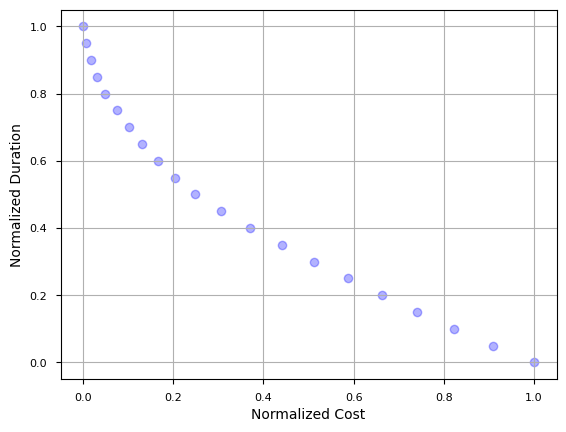

In [ ]:
# Visualizing the Pareto front - normalized values

fig, ax = plt.subplots()
x = [x['normalized_value_cost'] for x in optimal_solutions_normalized.values()]
y = [x['normalized_value_duration'] for x in optimal_solutions_normalized.values()]
c = 'blue'

ax.scatter(x, y, c=c, alpha=0.3)
ax.set_xlabel(r'Normalized Cost', fontsize=10)
ax.set_ylabel(r'Normalized Duration', fontsize=10)
ax.grid(True)
plt.tick_params(labelsize=8, pad=6);
plt.show()


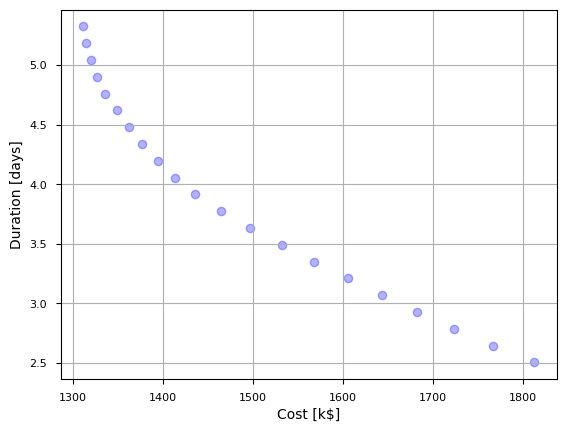

In [ ]:
# Visualizing the Pareto front with real cost and duration values

fig, ax = plt.subplots()
x = [x['cost'] / 1000 for x in optimal_solutions.values()]
y = [x['duration'] for x in optimal_solutions.values()]
c = 'blue'

ax.scatter(x, y, c=c, alpha=0.3)
ax.set_xlabel(r'Cost [k$]', fontsize=10)
ax.set_ylabel(r'Duration [days]', fontsize=10)
ax.grid(True)
plt.tick_params(labelsize=8, pad=6);

plt.show()


In [ ]:
print('Number of solutions investigated: ', len(optimal_solutions))
print('Number of unique solutions: ', len(set([x['share_road'] for x in optimal_solutions.values()])))


Number of solutions investigated:  21
Number of unique solutions:  21


In [ ]:
# Visualizing the individual solutions

data = {
    'Epsilon (%)': [key for key, val in optimal_solutions.items()],
    'Cost (k$)': [round(val['cost'] / 1000, 2) for key, val in optimal_solutions.items()],
    'Duration (days)': [round(val['duration'], 2) for key, val in optimal_solutions.items()],
    'Share Road (%)': [round(val['share_road'], 2) for key, val in optimal_solutions.items()],
    'Share Rail (%)': [round(val['share_rail_road'], 2) for key, val in optimal_solutions.items()],
}

df_solutions = pd.DataFrame(data)
df_solutions


,Epsilon (%),Cost (k$),Duration (days),Share Road (%),Share Rail (%)
0,1.00,1311.31,5.32,34.07,65.93
1,0.95,1314.92,5.18,37.43,62.57
2,0.90,1319.61,5.04,41.37,58.63
3,0.85,1326.36,4.90,45.33,54.67
4,0.80,1336.09,4.76,49.12,50.88
5,0.75,1348.99,4.62,52.49,47.51
6,0.70,1362.31,4.48,55.66,44.34
7,0.65,1376.30,4.34,60.96,39.04
8,0.60,1394.57,4.20,64.68,35.32
9,0.55,1413.73,4.05,67.71,32.29
